In [1]:
from __future__ import print_function
import os, sys, glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
import pickle

from config import CURRENT_DIR
CHESSBOARD_IMAGES_PATH = os.path.join(CURRENT_DIR, "../camera_cal")
IMAGE_PATH = os.path.join(CURRENT_DIR, "../test_images")
VIDEO_PATH = os.path.join(CURRENT_DIR, "../test_videos")
VIDEO_OUTPUT_PATH = os.path.join(CURRENT_DIR, "../output_videos")
IMAGE_OUTPUT_PATH = os.path.join(CURRENT_DIR, "../output_images")
sys.path.append(os.path.join(CURRENT_DIR, ".."))

# Utility function 

In [2]:
def plt_imshow_multiple(imgs, image_names, callback_func = plt.imshow, cmap=None):
    figure = plt.figure(figsize=(20, 20))
    num_rows = 3
    num_cols = int(np.ceil(len(imgs) / num_rows))

    ax = []
    for i in range(len(imgs)):
        ax.append(figure.add_subplot(num_rows, num_cols, i+1))
        ax[-1].set_title(image_names[i])
        if (callback_func == plt.imshow):
            callback_func(cv2.cvtColor(imgs[i], cv2.COLOR_BGR2RGB), cmap)
        else:
            callback_func(imgs[i])


    plt.show()
    
def plt_imshow_bgr(img):
    figure = plt.figure(figsize=(20, 20))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
def plt_imshow_gray(img):
    figure = plt.figure(figsize=(20, 20))
    plt.imshow(img, cmap="gray")
    
def save_output_images(imgs, image_names, prefix=""):
    for img, image_name in zip(imgs, image_names):
        image_name = prefix + "_" + image_name
        cv2.imwrite(os.path.join(IMAGE_OUTPUT_PATH, image_name), img)

# Camera Calibration

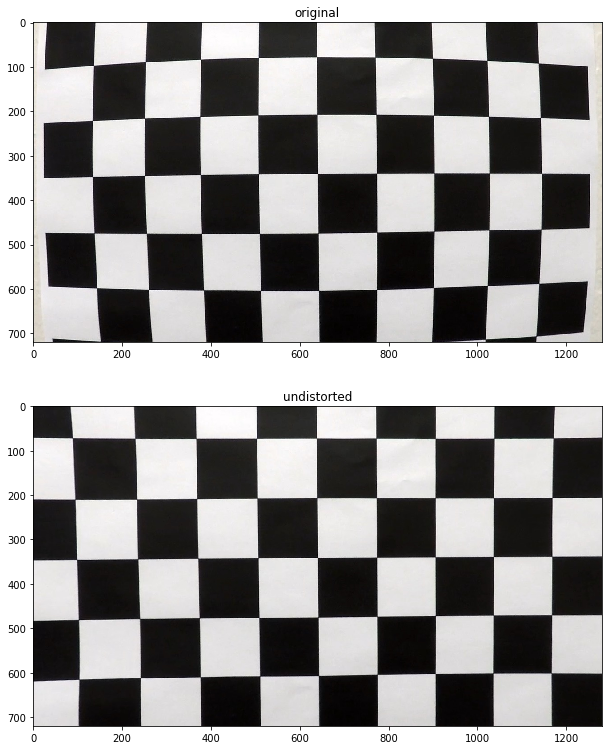

In [3]:
chessboard_images_names = glob.glob(CHESSBOARD_IMAGES_PATH + "/calibration*.jpg")

NUMBER_CORNER_XAXIS = 9
NUMBER_CORNER_YAXIS = 6

objp = np.zeros((NUMBER_CORNER_XAXIS*NUMBER_CORNER_YAXIS, 3), np.float32)
objp[:,:2] = np.mgrid[0:NUMBER_CORNER_YAXIS, 0:NUMBER_CORNER_XAXIS].T.reshape(-1,2)

objpoints = []
imgpoints = []

img_size = None
for idx, fname in enumerate(chessboard_images_names):
    img = cv2.imread(fname)
    if (not img_size):
        img_size = (img.shape[1], img.shape[0])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    ret, corners = cv2.findChessboardCorners(gray, (NUMBER_CORNER_YAXIS,NUMBER_CORNER_XAXIS), None)

    del img
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# save to pickle form
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open(os.path.join(CURRENT_DIR, "../models/calibration.p"), "wb"))

sample_chessboard_img = cv2.imread(os.path.join(CHESSBOARD_IMAGES_PATH, "calibration1.jpg"))
sample_undistorted_img = cv2.undistort(sample_chessboard_img, mtx, dist, None, mtx)

plt_imshow_multiple([sample_chessboard_img, sample_undistorted_img], ["original", "undistorted"])
save_output_images([sample_chessboard_img, sample_undistorted_img], ["original.jpg", "undistorted.jpg"], "chessboard")

# Process Test Image

In [4]:
if "mtx" not in dir() or "dist" not in dir():
    dist_pickle = pickle.load(open(os.path.join(CURRENT_DIR, "../models/calibration.p"), "rb"))
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]


import os
image_names = os.listdir(IMAGE_PATH)
imgs = [cv2.imread(os.path.join(IMAGE_PATH, image_name)) for image_name in image_names]
undistorted_imgs = [cv2.undistort(img, mtx, dist, None, mtx) for img in imgs]

# Original test images

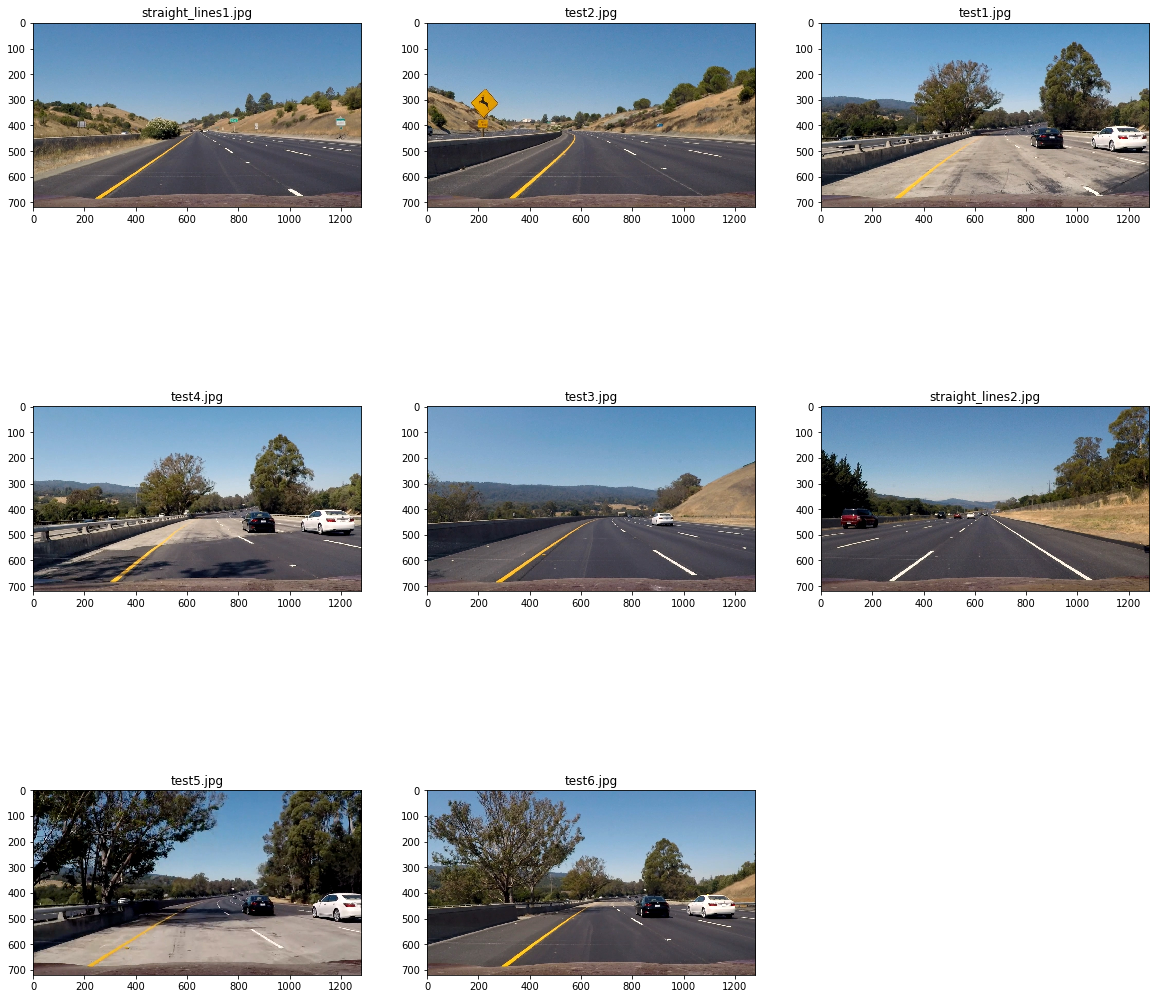

In [5]:
plt_imshow_multiple(imgs, image_names)

# Undistorted images

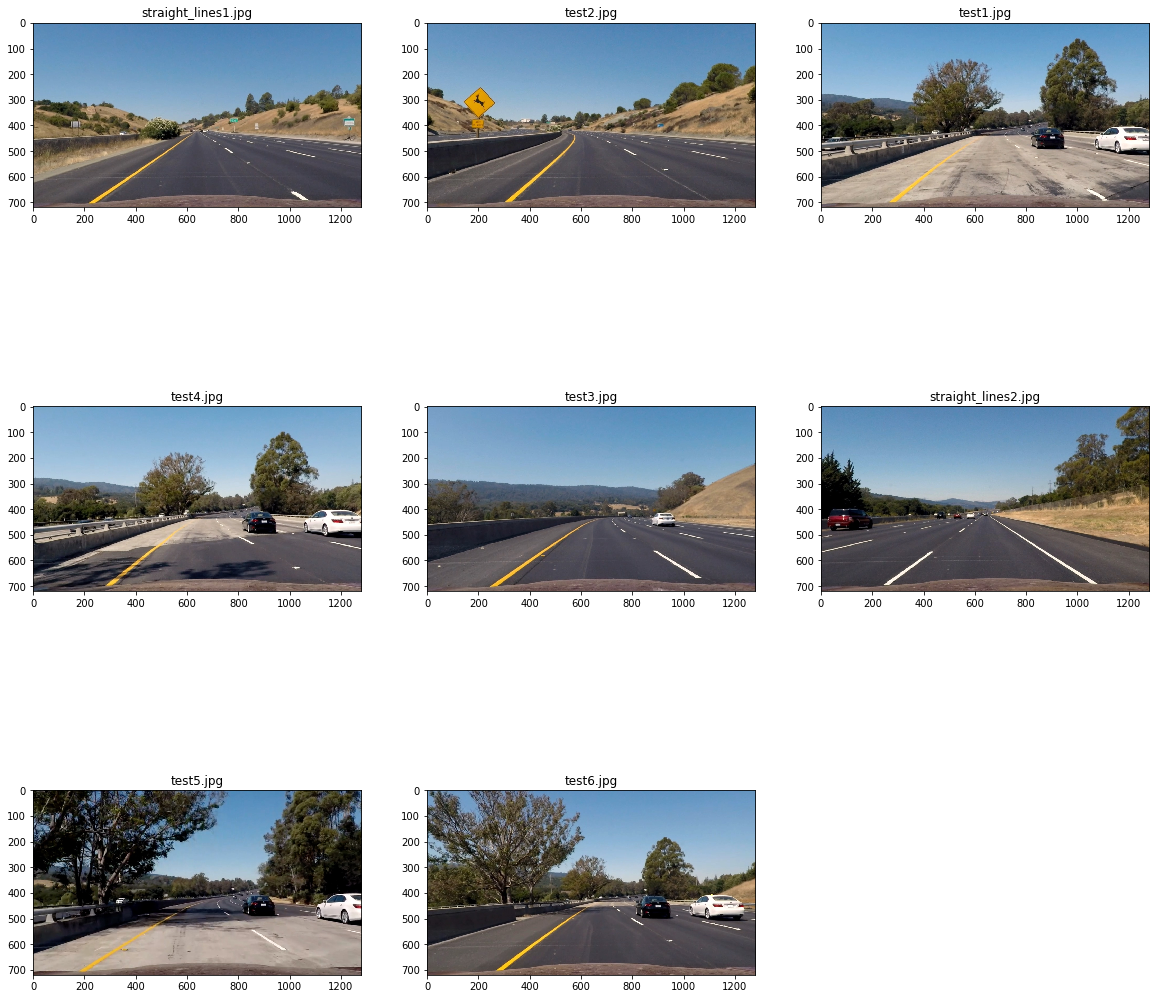

In [6]:
plt_imshow_multiple(undistorted_imgs, image_names)
save_output_images(undistorted_imgs, image_names, "undistorted_img")

# Sliding windows to search for pixels for polynomial fitting

In [7]:
from lane_line_detector import LaneLineDetector
transformed_imgs = []
thresholded_imgs = []
out_imgs = []
final_results = []

for i, img in enumerate(undistorted_imgs):
    lld = LaneLineDetector(img, mtx=mtx,dist=dist, record_process=True)
    thresholded_img, left_fit_param, right_fit_param, left_fitx, right_fitx, ploty, out_img = lld.estimate_lanes()
    final_result = lld.visualize_result(thresholded_img, left_fit_param, right_fit_param, left_fitx, right_fitx, ploty)
    transformed_imgs.append(lld.transformed_img)
    thresholded_imgs.append(lld.thresholded_img)
    out_imgs.append(lld.out_img)
    final_results.append(final_result)
    
    del lld

img of type BGR
img of type BGR
img of type BGR
img of type BGR
img of type BGR
img of type BGR
img of type BGR
img of type BGR


# Perspective transform

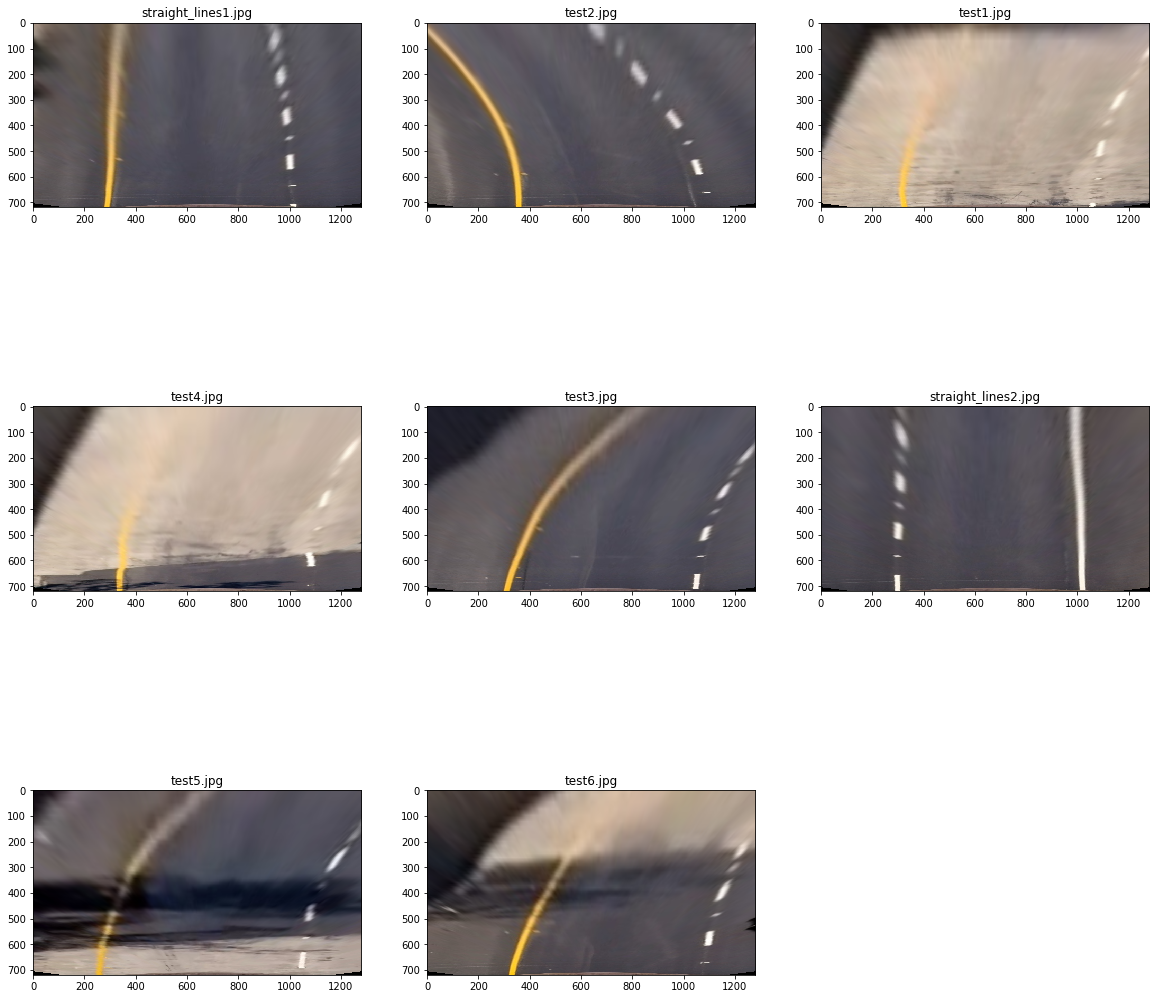

In [8]:
plt_imshow_multiple(transformed_imgs, image_names)
save_output_images(transformed_imgs, image_names, "transformed_img")

# Thresholding

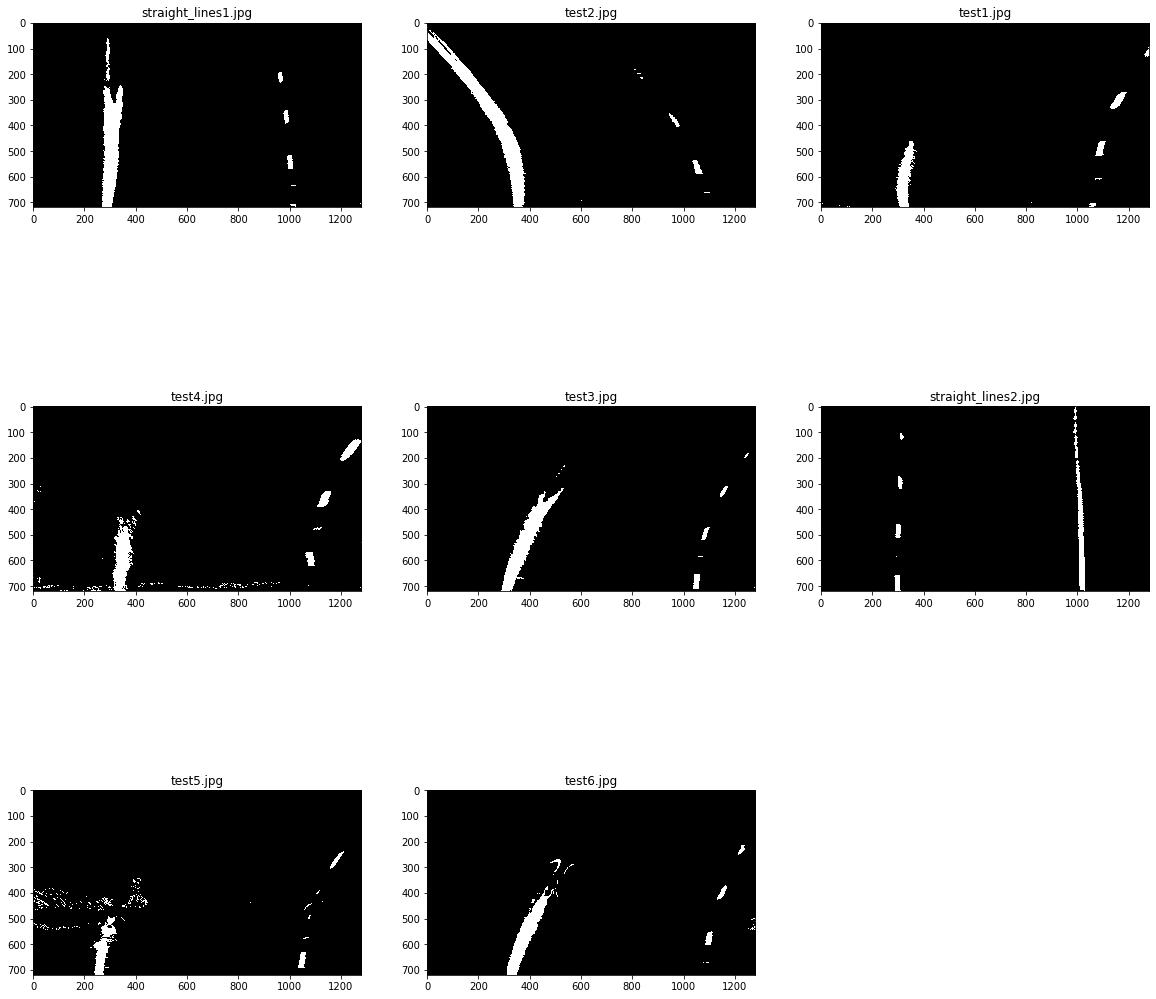

In [9]:
thresholded_imgs_3c = list(map(lambda img : img * 255, thresholded_imgs))
plt_imshow_multiple(thresholded_imgs_3c, image_names)
save_output_images(thresholded_imgs_3c, image_names, "thresholded_img")

# Slide-windows-based searching

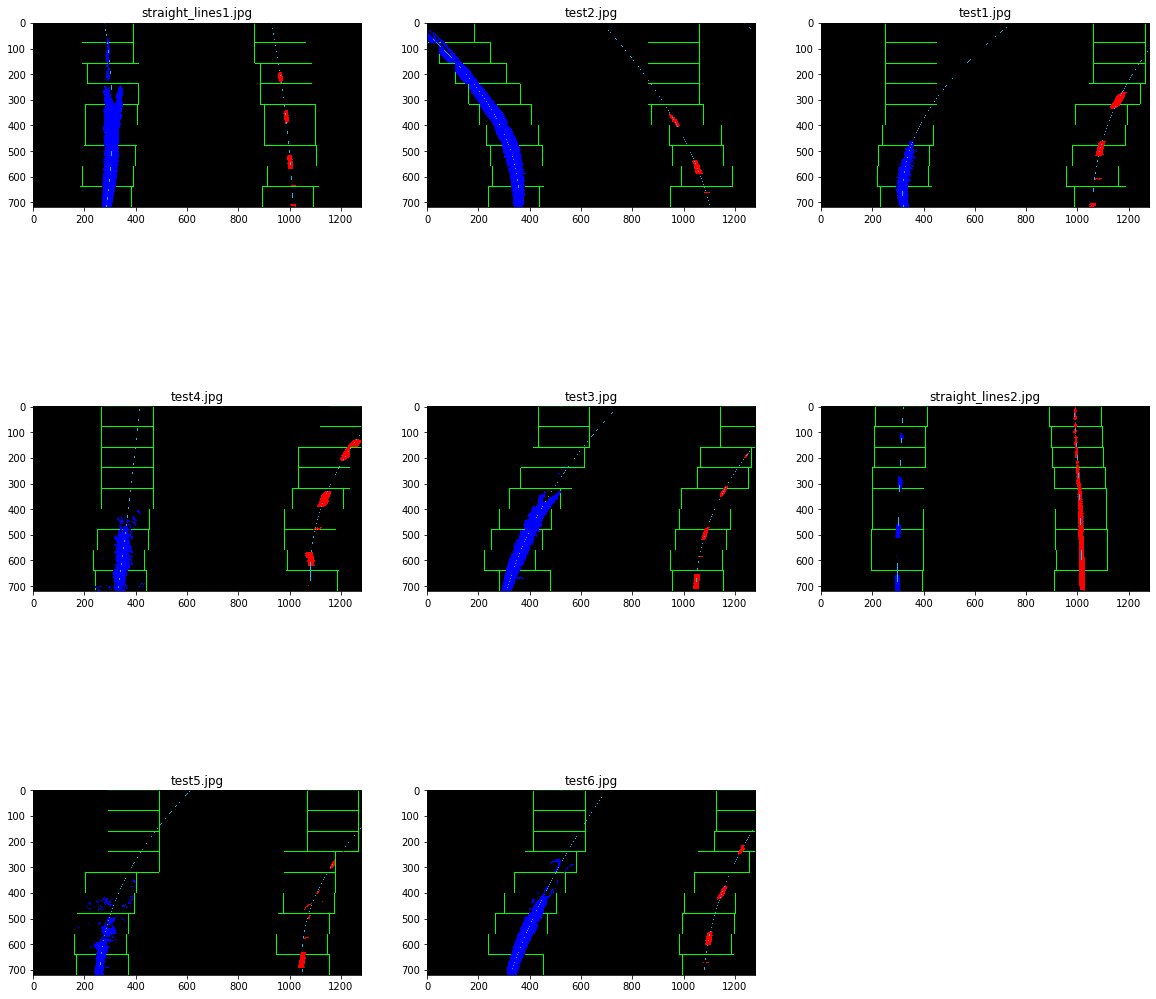

In [10]:
plt_imshow_multiple(out_imgs, image_names)
save_output_images(out_imgs, image_names, "sliding_windows")

# Final output result

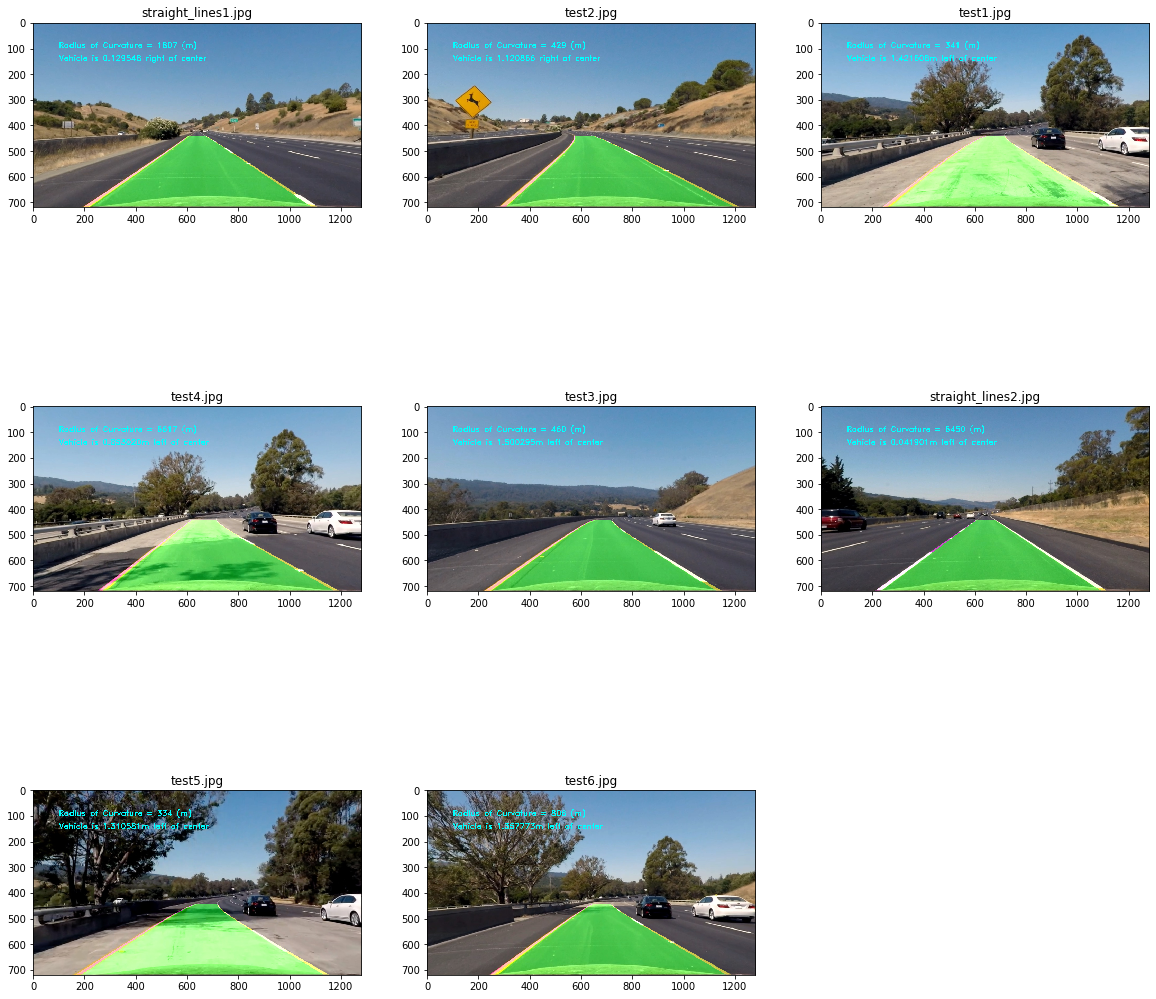

In [11]:
plt_imshow_multiple(final_results, image_names)
save_output_images(final_results, image_names, "final_result")

# Test on videos

In [12]:
from moviepy.editor import VideoFileClip
from IPython.core.display import HTML

In [13]:
left_fit_param = None
right_fit_param = None

def process_image(image):
    global left_fit_param
    global right_fit_param
    lld = LaneLineDetector(image, mtx=mtx,dist=dist)
    thresholded_img, left_fit_param, right_fit_param, left_fitx, right_fitx, ploty, out_img = lld.estimate_lanes(left_fit_param, right_fit_param)
    final_result = lld.visualize_result(thresholded_img, left_fit_param, right_fit_param, left_fitx, right_fitx, ploty)

    del lld
    
    return final_result

In [14]:
project_video_path = os.path.join(os.path.join(VIDEO_PATH, "project_video.mp4"))
project_video = VideoFileClip(project_video_path)
project_video_output_path = os.path.join(os.path.join(VIDEO_OUTPUT_PATH, "output_project_video.mp4"))

processed_project_video = project_video.fl_image(process_image)
%time processed_project_video.write_videofile(project_video_output_path, audio=False)

t:   0%|▋                                                                                                                                                                                                                                                                         | 3/1260 [00:00<01:00, 20.71it/s, now=None]

Moviepy - Building video /home/buggy/publicWorkspace/dev/CarND-Advanced-Lane-Lines/notebooks/../output_videos/output_project_video.mp4.
Moviepy - Writing video /home/buggy/publicWorkspace/dev/CarND-Advanced-Lane-Lines/notebooks/../output_videos/output_project_video.mp4



Moviepy - Done !
Moviepy - video ready /home/buggy/publicWorkspace/dev/CarND-Advanced-Lane-Lines/notebooks/../output_videos/output_project_video.mp4
CPU times: user 2min 53s, sys: 2.17 s, total: 2min 55s
Wall time: 43.3 s


In [15]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_video_output_path))